In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-surprise
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

In [226]:
df = pd.read_csv("/content/fashion_products.csv")

In [227]:
df.head()

,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


In [228]:
df.isnull().sum()

,0
User ID,0
Product ID,0
Product Name,0
Brand,0
Category,0
Price,0
Rating,0
Color,0
Size,0


In [229]:
df.duplicated().sum()

0

In [230]:
df

,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M
...,...,...,...,...,...,...,...,...,...
995,20,996,Shoes,Zara,Women's Fashion,55,1.620081,Black,M
996,42,997,Sweater,Nike,Kids' Fashion,13,1.544464,Green,L
997,9,998,Sweater,Zara,Men's Fashion,47,3.961913,White,L
998,8,999,T-shirt,Zara,Women's Fashion,68,3.089722,Blue,S


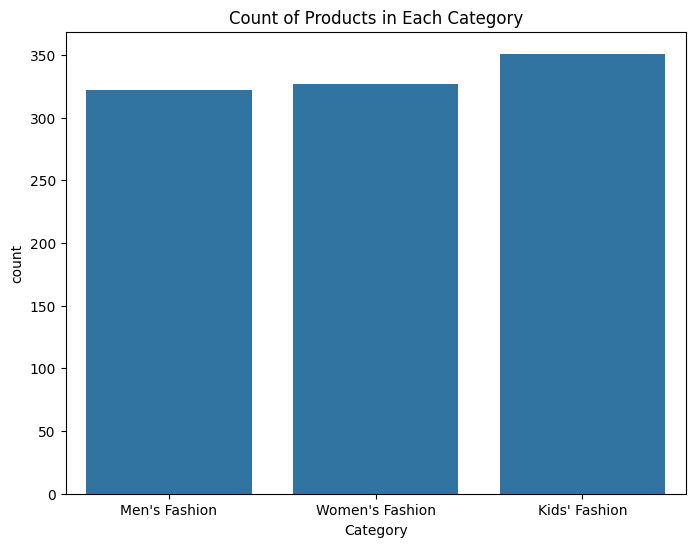

In [231]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Category')
plt.title('Count of Products in Each Category')
plt.show()

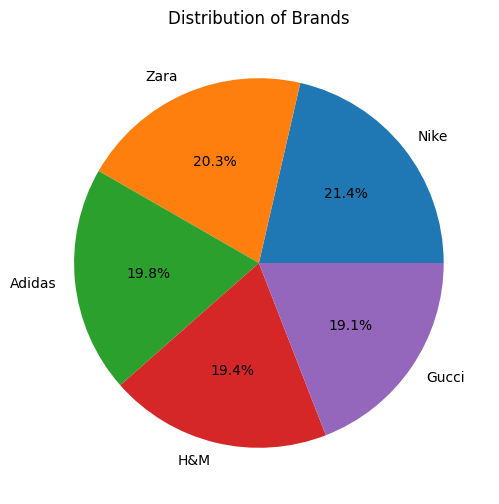

In [232]:
plt.figure(figsize=(8, 6))
df['Brand'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Brands')
plt.ylabel('')
plt.show()

In [223]:
df.shape

(1000, 9)

In [210]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_normalize = ['Price', 'Rating']
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
print(df)

     User ID  Product ID Product Name   Brand         Category     Price  \
0         19           1        Dress  Adidas    Men's Fashion  0.333333   
1         97           2        Shoes     H&M  Women's Fashion  0.800000   
2         25           3        Dress  Adidas  Women's Fashion  0.377778   
3         57           4        Shoes    Zara    Men's Fashion  0.144444   
4         79           5      T-shirt  Adidas    Men's Fashion  0.766667   
..       ...         ...          ...     ...              ...       ...   
995       20         996        Shoes    Zara  Women's Fashion  0.500000   
996       42         997      Sweater    Nike    Kids' Fashion  0.033333   
997        9         998      Sweater    Zara    Men's Fashion  0.411111   
998        8         999      T-shirt    Zara  Women's Fashion  0.644444   
999       91        1000        Shoes  Adidas  Women's Fashion  0.766667   

       Rating   Color Size  
0    0.010582   Black   XL  
1    0.758829   Black    L  


In [245]:
# Store original ratings before normalization for later use
original_ratings = df[['User ID', 'Brand', 'Rating']].copy()

# Create the Surprise dataset
reader = Reader(rating_scale=(0, 5))  # Ensure the scale reflects the original ratings
data = Dataset.load_from_df(df[['User ID', 'Brand', 'Rating']], reader)

# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2)

# Collaborative Filtering using SVD
algo_cf = SVD()
algo_cf.fit(trainset)

# Brand-Based Recommendation System
def brand_recommendation(user_id, num_recommendations):
    # Collaborative Filtering predictions
    cf_predictions = algo_cf.test(testset)

    # Filter predictions based on user ID and brand
    user_brand_predictions = [
        pred for pred in cf_predictions
        if pred.uid == user_id and pred.iid in df[df['User ID'] == user_id]['Brand'].unique()
    ]

    # Sort the predictions by rating in descending order
    user_brand_predictions.sort(key=lambda x: x.est, reverse=True)

    # Get the top N recommendations
    top_recommendations = user_brand_predictions[:num_recommendations]

    # Print the original ratings before normalization
    original_ratings_user = original_ratings[original_ratings['User ID'] == user_id][['Brand', 'Rating']]
    print(f"Original Ratings for User ID {user_id}:")
    print(original_ratings_user)

    return top_recommendations

# Example usage: Get brand recommendations for User ID 7, top 3 recommendations
user_id = 7
num_recommendations = 3
recommendations = brand_recommendation(user_id, num_recommendations)

# Print the recommendations with original ratings
print(f"\nBrand Recommendations for User ID {user_id}:")
for recommendation in recommendations:
    brand = recommendation.iid
    # Find the original rating for the recommended brand
    original_rating = original_ratings[(original_ratings['User ID'] == user_id) &
                                       (original_ratings['Brand'] == brand)]['Rating'].values[0]
    estimated_rating_normalized = recommendation.est  # This is the normalized estimated rating
    estimated_rating_original = estimated_rating_normalized * 5  # Convert back to the original scale (0 to 5)

    print(f"Brand: {brand}, Original Rating: {original_rating}, Estimated Rating (Original Scale): {estimated_rating_original:.2f}")

Original Ratings for User ID 7:
      Brand    Rating
126    Zara  0.969762
216   Gucci  0.109646
303  Adidas  0.075102
325    Zara  0.580111
353   Gucci  0.718260
365    Nike  0.790664
387     H&M  0.781607
431     H&M  0.310423
512    Zara  0.767702
529  Adidas  0.590781
601    Zara  0.838199
637  Adidas  0.979262

Brand Recommendations for User ID 7:
Brand: Gucci, Original Rating: 0.1096460535793089, Estimated Rating (Original Scale): 3.82
Brand: Adidas, Original Rating: 0.0751019679103534, Estimated Rating (Original Scale): 3.60
Brand: Zara, Original Rating: 0.9697615050882289, Estimated Rating (Original Scale): 2.97


In [244]:
# Evaluate the model on the test set

predictions = algo_cf.test(testset)

# Compute RMSE
rmse = accuracy.rmse(predictions)

# Compute MAE
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


Predictions: [Prediction(uid=68, iid='Zara', r_ui=0.25164402712759143, est=0.48130334919901174, details={'was_impossible': False}), Prediction(uid=62, iid='Zara', r_ui=0.450216766333218, est=0.4695544976765281, details={'was_impossible': False}), Prediction(uid=33, iid='Zara', r_ui=0.6826135465674374, est=0.552296905597805, details={'was_impossible': False}), Prediction(uid=46, iid='Gucci', r_ui=0.6045453369744884, est=0.5342537239419851, details={'was_impossible': False}), Prediction(uid=91, iid='Nike', r_ui=0.5203255847978321, est=0.5739122140991156, details={'was_impossible': False}), Prediction(uid=22, iid='Nike', r_ui=0.7373917436360895, est=0.4245243732856882, details={'was_impossible': False}), Prediction(uid=7, iid='Nike', r_ui=0.7906637934911676, est=0.47512407125099665, details={'was_impossible': False}), Prediction(uid=8, iid='Zara', r_ui=0.015435160728028086, est=0.6027954061502243, details={'was_impossible': False}), Prediction(uid=80, iid='Adidas', r_ui=0.9366709433424043